In [12]:
import math
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

import wald_wolfowitz

In [13]:
from qbstyles import mpl_style

mpl_style(dark=True)

In [180]:
def plot_z(z_plot, title="individual game z-scores, 2023-24 season", do_bell=True):
    x = np.linspace(-3,3,200)
    if do_bell:
        plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), color='w')

    out = plt.hist(z_plot, bins=np.arange(-3,3,.5), density=True, color='r')
    plt.title(title)

# Approximately Normal

When I looked at the individual game data, I was looking at some very small sample sizes. The Wald Wolfowitz test says that the number of streaks in random data is approximately normal. What does "approximately" mean?

Say a player makes 2 baskets and misses 3 baskets in a game. How could such a small sample size be "approximately normal"?

It can't, of course. below is a bar chart of the probabilities of each number of streaks, overlaid with a bell curve. Not very normal, is it?

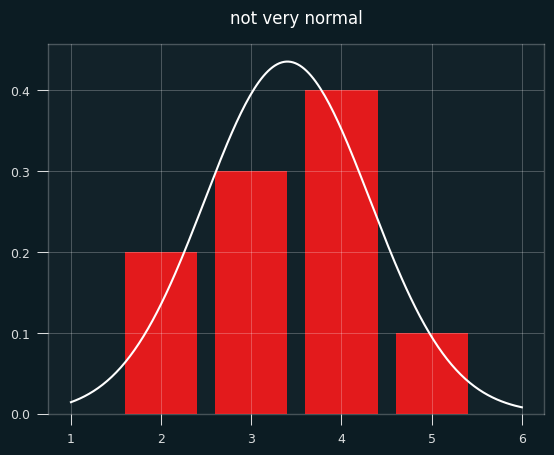

In [88]:
exp_mean = wald_wolfowitz.get_expected_streaks(2,3)
exp_var = wald_wolfowitz.get_variance(2,3, exp_mean)
line_x = np.linspace(1, 6, 200)
_line = plt.plot(line_x, scipy.stats.norm.pdf(line_x, exp_mean, np.sqrt(exp_var)), color='w')


sss = wald_wolfowitz.get_exact_pmf(2,3)
_bar = plt.bar(sss.index, sss.values)

_out = plt.title("not very normal")

plt.minorticks_off()

How did I get the probabilities for each outcome? Well, I used a formula, which I'll get to. But if I wanted to, I could brute-force it by generating every possible string of 1's and 0's with a certain count of each, then calculate the number of streaks of each length:

In [ ]:
import itertools
import math
import streak_converter
import pandas as pd

def get_permutations(wins, losses):
    to_permute = ([0] * wins) + ([1] * losses)

    # I don't know why itertools doesn't have a "distinct permutations" function
    perms = set()
    for x in itertools.permutations(to_permute, wins+losses):
        perms.add(x)
    return perms

def generate_exact_df(wins, losses):
    perms = get_permutations(wins, losses)

    expected_len = math.factorial(wins+losses)  / (math.factorial(wins) * math.factorial(losses))
    assert len(perms) == expected_len, "I forgot how to do math!"

    exact_df = pd.DataFrame(columns=["zeroes", "ones", "streaks", "as_str"])
    for x in list(perms):
        perm = pd.Series(x)
        streak_data = streak_converter.convert_to_streaks(perm)
        exact_df.loc[len(exact_df)]  = [streak_data['misses'], streak_data['makes'], 
                            streak_data['total_streaks'], "".join(perm.replace(0, "0").replace(1, "1"))]
    return exact_df


## Continuity corrections

To make things a bit more interesting, let's say the player made 7 shots and missed 4. That's enough for the graph to look more like a proper bell curve.

In [17]:
exact_df = generate_exact_df(7,4)

In [18]:
exact_df.head()

,zeroes,ones,streaks,as_str
0,7,4,6,00100001101
1,7,4,5,10000001101
2,7,4,7,00010010110
3,7,4,7,00011001010
4,7,4,8,00010100101


In [19]:
len(exact_df)

330

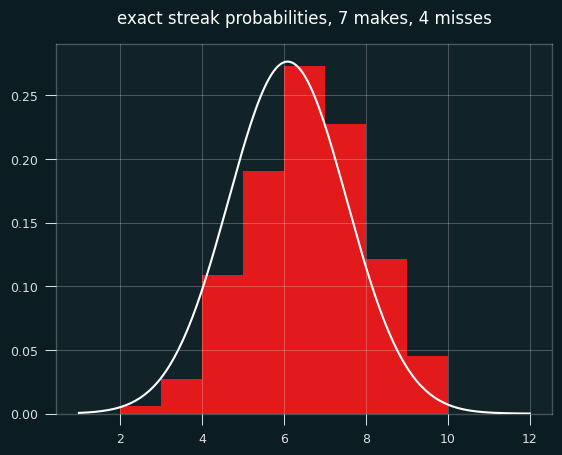

In [95]:
_exact_hist = plt.hist(exact_df.streaks, bins=range(2,11), density=True)
plt.title("exact streak probabilities, 7 makes, 4 misses")
plt.minorticks_off()

###
exp_mean = wald_wolfowitz.get_expected_streaks(7,4)
exp_var = wald_wolfowitz.get_variance(7,4, exp_mean)
line_x = np.linspace(1, 12, 200)
_line = plt.plot(line_x, scipy.stats.norm.pdf(line_x, exp_mean, np.sqrt(exp_var)), color='w')

The bell curve looks skewed relative to the histogram, right? That's what happens when you model a discrete distribution (the number of streaks) with a continuous one -- the normal distribution.

A continuous distribution has zero probability at any single point, so we always calculate the area under the curve between a range of values. The bar for exactly 7 streaks should line up with the probability of between 6.5 and 7.5 streaks in the normal approximation. 

So the curve should be shifted to the right a half a streak. Fixing this is called [continuity correction](https://en.wikipedia.org/wiki/Continuity_correction).

Here's the same graph with the continuity correction applied:

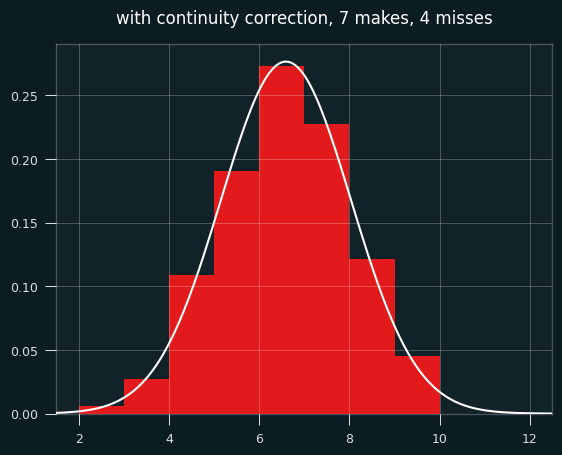

In [182]:
_exact_hist = plt.hist(exact_df.streaks, bins=range(2,11), density=True)
plt.title("with continuity correction, 7 makes, 4 misses")
plt.minorticks_off()

## add .5 to line_x to shift curve over
_line = plt.plot(.5 + line_x, scipy.stats.norm.pdf(line_x, exp_mean, np.sqrt(exp_var)), color='w')

So... better, but there's still a problem. The normal approximation will give a nonzero probability to impossible things. In this case of 7 wins and 7 losses, the minimum possible number of streaks is 2 and the max is 9 (alternate wins and losses till you run out of losses, then have a string of wins at the end.)

Yet the normal approximation says there's a nonzero chance of 10, or 11, or even a million streaks. The probabilities are tiny, but the normal distribution never ends. These differences go away with big sample sizes, but they're worth worrying about for small sample sizes.

Is that interfering with the results? Maybe. I'm trying to use the mean and the standard deviation to decide how "weird" each player is in the form of a z score. The z score gives the likelihood of the data happening by chance, given certain assumptions. If the assumptions don't hold, the z score, and using it to interpret how weird things are, is suspect.


# Percentile ranks

Let's say we're trying to assign percentiles to each number of streaks (compared to if they came from a random process, like flips of a weighted coin). 1st percentile would be super streaky, 99th percentile super un-streaky.

Based on the *brute force* probabilities shown below, the case of 2 streaks is easy -- it's definitely in the first percentile. But the rest of them require a decision. Let's say we get 6 streaks. That happens 27% of the time. 5 or fewer streaks happens 33% of the time. So we could say 6 streaks is equal to the 33rd percentile, the `33%+27% = 60`th percentile, or some value in between those two numbers.

In [22]:
brute_force = pd.Series(_exact_hist[0], index=_exact_hist[1][:-1].astype("int"))

brute_force

2    0.006061
3    0.027273
4    0.109091
5    0.190909
6    0.272727
7    0.227273
8    0.121212
9    0.045455
dtype: float64

In [23]:
brute_force.cumsum()

2    0.006061
3    0.033333
4    0.142424
5    0.333333
6    0.606061
7    0.833333
8    0.954545
9    1.000000
dtype: float64

The obvious way of deciding the percentile for a discrete distribution is to take the average of the upper and lower bound.

In [24]:
lower_bound = sum(brute_force[brute_force.index < 6].values)
print(lower_bound)
upper_bound = sum(brute_force[brute_force.index <= 6].values)
print(upper_bound)
np.mean([lower_bound, upper_bound])

0.33333333333333337
0.6060606060606061


np.float64(0.4696969696969697)

The wikipedia article on [percentile rank](https://en.wikipedia.org/wiki/Percentile_rank) writes the rule in a different, less intuitive way, but it's still just the average of the two.

In [25]:
sum(brute_force[brute_force.index <= 6].values) - (.5 * brute_force[brute_force.index == 6].values)

array([0.46969697])

How close is the normal approximation here? We could take the z-score from the Wald Wolfowitz test, and convert it back to a percentile:

In [26]:
ww_z = (6 - exp_mean) / np.sqrt(exp_var) # z score from wald-wolfowitz
scipy.stats.norm.cdf(ww_z) # percentile score from w-w

np.float64(0.4748856096817421)

So the two methods are going to give very similar results, but the percentile rank method is a linear interpolation of the lower and upper bound values, whereas the z score is going to be the average point on a curve between the lower and upper bounds.

Here's a kind of awkward looking graph of what's going on. We're looking at the cumulative density functions.

The red line is one for the exact probabilities. The white line is the CDF for the normal approximation. Where the white line hits the red line is the percentile estimate (.475) -- well, percentile / 100.

The green line is a linear interpolation of the exact probabilities. Where it hits the vertical red line gives the percentile rank for 6 (.470). 

The percentile rank is a straight line and the normal distribution is curved.

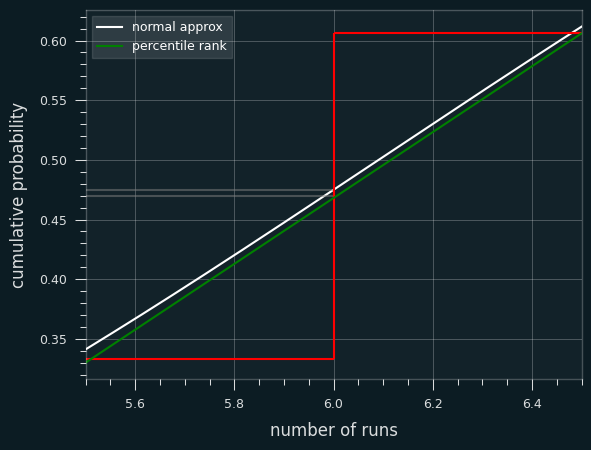

In [225]:
x = np.linspace(5.5,6.5,200)

plt.rcParams['axes.xmargin'] = 0

cdf = scipy.stats.norm.cdf(x, exp_mean, np.sqrt(exp_var))
_line = plt.plot(x, cdf, color="w", label="normal approx")

# foo =  pdf[100]
brute_force.cumsum()[3:6]

plt.hlines(.333, 5.5, 6, color="red")
plt.hlines(.606, 6, 6.5, color="red")

plt.hlines(.470, 5.5,6, color="grey", alpha=.5)
plt.hlines(.475, 5.5,6, color="grey", alpha=.5)

plt.vlines(6, .333, .606, color="red")


plt.axline((5.5,.33),(6.5,.606), color='green', label="percentile rank")

plt.xlabel("number of runs")
plt.legend()
_out = plt.ylabel("cumulative probability")


this isn't exactly what I wanted but I ran out of time.

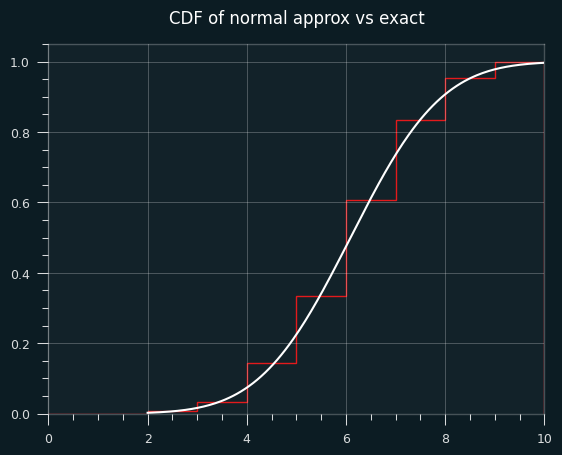

In [ ]:
x = np.linspace(2,10,200)


cdf = scipy.stats.norm.cdf(x, exp_mean, np.sqrt(exp_var))
_line = plt.plot(x, cdf, color="w", label="normal approx")

stair_probs = [0, 0] + list(brute_force.cumsum())

plt.stairs(stair_probs)

_out = plt.title("CDF of normal approx vs exact")
#plt.minorticks_off()

In [211]:
brute_force.cumsum()

2    0.006061
3    0.033333
4    0.142424
5    0.333333
6    0.606061
7    0.833333
8    0.954545
9    1.000000
dtype: float64

Any type of interpolation is going to be "chunky" with a small number of data points. Each additional number of streaks bumps the z score by .7 standard deviations or so.


[TODO: include this in blog post????]

In [ ]:
bf_df = pd.DataFrame(brute_force)
bf_df['actual_prob'] = bf_df[0]
bf_df['num_runs']= bf_df.index
bf_df['cumu_prob'] = bf_df.actual_prob.cumsum()
del bf_df[0]

expected_streaks = wald_wolfowitz.get_expected_streaks(7,4)
exp_variance = wald_wolfowitz.get_variance(7,4,expected_streaks)

bf_df['ww_z_score'] = (bf_df.num_runs - expected_streaks) / ((exp_variance)**.5)
bf_df['cumu_prob_from_z_score'] = scipy.stats.norm.cdf(bf_df['ww_z_score'])

# not interesting/hard to explain
#bf_df['prob_diff'] = bf_df['cumu_prob'] - bf_df['cumu_prob_from_z_score']

In [189]:
bf_df

,actual_prob,num_runs,cumu_prob,ww_z_score,cumu_prob_from_z_score
2,0.006061,2,0.006061,-2.834734,0.002293
3,0.027273,3,0.033333,-2.141799,0.016105
4,0.109091,4,0.142424,-1.448864,0.073688
5,0.190909,5,0.333333,-0.755929,0.224846
6,0.272727,6,0.606061,-0.062994,0.474886
7,0.227273,7,0.833333,0.629941,0.735633
8,0.121212,8,0.954545,1.322876,0.907062
9,0.045455,9,1.000000,2.015811,0.978090


## Calculating the exact odds with a counting formula

It's possible to figure out the number of combinations of 1's and 0's without generating them all like I did in the "brute force" example above. The formula is worked out nicely here using the basic rules of combinatorics: [https://online.stat.psu.edu/stat415/lesson/21/21.1](https://online.stat.psu.edu/stat415/lesson/21/21.1)

I put a little caching on my implementation, so it's pretty fast.

In [29]:
pmf = wald_wolfowitz.get_exact_pmf(7,4)

as expected, the formula and the brute force method match.

In [30]:
pmf - brute_force

2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float64

## Is Wald-Wolfowitz unbiased?
Yeah. The test provides the exact expected value of the number of streaks. It's not just, like, a pretty good estimate. It is the (weighted) mean of the exact probabilities I calculated above.

The mean of all the streak lengths is 6.0909:

In [31]:
exact_df.streaks.describe()

count    330.000000
mean       6.090909
std        1.445329
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: streaks, dtype: float64

the wald-wolfowitz test gives the expected value (as you might recall, it's 1 plus the harmonic mean of 7 and 4) = $1 + \frac{2*7*4}{7+4} = 6\frac{1}{11}$:

In [32]:
expected_streaks = wald_wolfowitz.get_expected_streaks(7,4)
expected_streaks

6.090909090909091

The variance calculated from Wald-Wolfowitz is very, very close to the actual value. Above, the "brute force" data has a standard deviation of 1.445, and the Wald-Wolfowitz test calculates it as 1.443. Not bad.

In [33]:
np.sqrt(wald_wolfowitz.get_variance(7,4,expected_streaks))

np.float64(1.443137078762504)

## Is what I'm doing fair?
In the case of individual game data and calculating z-scores, maybe not! Exact percentile ranks are more appropriate for small sample sizes than the normal approximation.

I decided to double check my analysis of individual player games.
TODO: Here's some tedious ETL I should probably move

In [34]:
shots =  pd.read_csv("kaggle_data/NBA_2024_Shots.csv")

combined_df = pd.DataFrame(columns=["player_id", "game_id", "makes", 
                                "misses", "total_streaks", "raw_data"])
combined_df = combined_df.set_index(["player_id", "game_id"])


for key, results in shots.groupby(["PLAYER_ID", "GAME_ID"])["SHOT_MADE"]:
    streak_data = "".join(results.replace(True, "W").replace(False, "L"))
    as_streaks = streak_converter.convert_to_streaks(False, streak_data)

    combined_df.loc[key, :] = [as_streaks['makes'], as_streaks['misses'],
                                  as_streaks['total_streaks'], as_streaks['raw_data']]

combined_df['expected_streaks'] = wald_wolfowitz.get_expected_streaks(combined_df.makes, combined_df.misses)

clean_df = combined_df[(combined_df.makes + combined_df.misses) > 3].copy()
clean_df['variance'] = wald_wolfowitz.get_variance(clean_df.makes, 
                                                      clean_df.misses, 
                                                      clean_df.expected_streaks)
clean_df = clean_df[clean_df.variance > 0].copy() # to prevent divide by zero below
clean_df['z_score'] = (clean_df.total_streaks - clean_df.expected_streaks) / ((clean_df.variance)**.5)


In [35]:
clean_df.head()


makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   

                   expected_streaks  variance   z_score  
player_id game_id                                        
2544      22300015         8.764706  3.282872  0.129863  
          22300026         6.454545  2.429752 -0.933139  
          22300036        11.636364  4.880756  1.975172  
          22300042              5.8  2.026667  0.842927  
          22300061              8.5      3.25   1.38675

I can use the percentile rank to get an equivalent z score.

In [ ]:
clean_df['exact_percentile_rank'] = None

for row_id, data in clean_df.iterrows():
    clean_df.loc[row_id, "exact_percentile_rank"] = wald_wolfowitz.get_percentile_rank(data['makes'], data['misses'], data['total_streaks'])
    
clean_df['z_from_percentile_rank'] = scipy.stats.norm.ppf(
    (clean_df['exact_percentile_rank'].values/ 100).tolist())

I can also get a percentile from the wald-wolfowitz z score

In [37]:
clean_df['ww_percentile'] = 100 * scipy.stats.norm.cdf(clean_df.z_score.tolist())

here's a scatter plot of the two ways to calculate the percentile on actual NBA player games. The dots above the trend line are where the Wald-Wolfowitz percentile is bigger than the percentile rank one. 

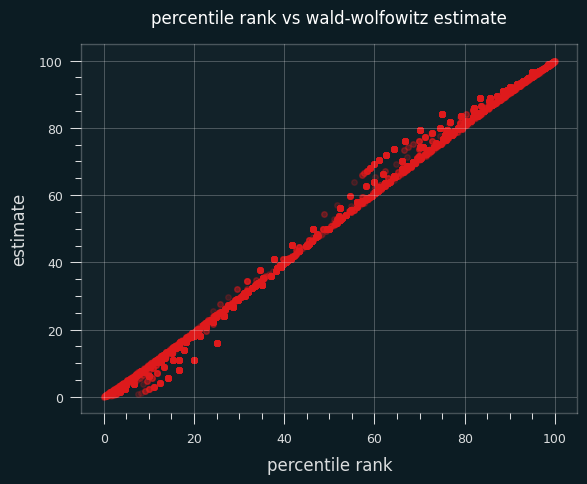

In [38]:
plt.scatter(data=clean_df, x='exact_percentile_rank', y='ww_percentile', alpha=.2)
plt.title("percentile rank vs wald-wolfowitz estimate")
_out = plt.xlabel("percentile rank")
_out =plt.ylabel("estimate")

In [157]:
sum(abs(clean_df.exact_percentile_rank - clean_df.ww_percentile) < .05)

984

The percentile rank tends to produce a lower value than the Wald-Wolfowitz estimate.

In [39]:
sum(clean_df.ww_percentile > clean_df.exact_percentile_rank)

10792

In [40]:
sum(clean_df.ww_percentile < clean_df.exact_percentile_rank)

7571

In [190]:
10792 / (7571 + 10792)

0.587703534280891

The same trends show in higher volume shooting games.

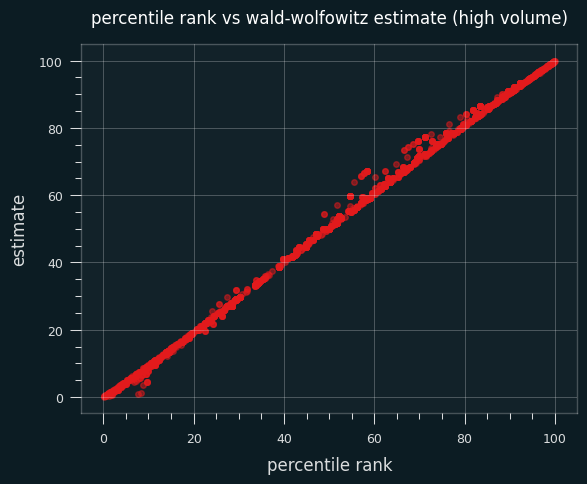

In [41]:
high_vol = clean_df[(clean_df.makes > 10) | (clean_df.misses > 10)]

_scatter = plt.scatter(data=high_vol, x='exact_percentile_rank', y='ww_percentile', alpha=.5)
_out = plt.title("percentile rank vs wald-wolfowitz estimate (high volume)")
_out = plt.xlabel("percentile rank")
_out =plt.ylabel("estimate")

In [42]:
sum(high_vol.ww_percentile > high_vol.exact_percentile_rank)

1438

In [43]:
sum(high_vol.ww_percentile < high_vol.exact_percentile_rank)

1091

The bias towards one side is more obvious if we look at a bar chart of the differences.

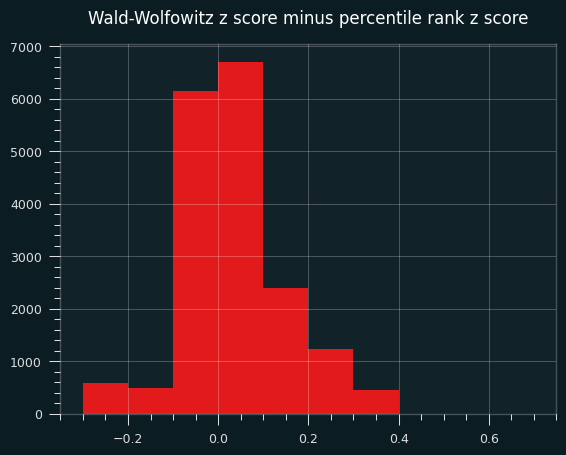

In [44]:
( clean_df.z_score - clean_df.z_from_percentile_rank).hist(bins=np.arange(-.3, .8, .1))
_out = plt.title("Wald-Wolfowitz z score minus percentile rank z score")

A percentile over 50, or a positive z score, means more streaks than average, thus less streaky than average. In other words, the Wald-Wolfowitz z-scores will be more flattering to the un-streaky side compared to percentile rank from the exact probabilities.

So I had to re-analyze the individual game data in this slightly harsher light.

In [45]:
clean_df.head()

makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   

                   expected_streaks  variance   z_score exact_percentile_rank  \
player_id game_id                                                               
2544      22300015         8.764706  3.282872  0.129863             54.476406   
          22300026         6.454545  2.429752 -0.933139             18.614719   
          22300036        11.636364  4.880756  1.975172             97.527643   
          22300042              5.8  2.026667  0.842927             78.571429   
          22300061              8.5      3.25   1.38675             91.083916   

                    z_from_percentile_rank  ww_percentile  
player_id game_id                                          
2544      22300015                0.112443      55.166243  
          22300026               -0.892184      17.537412  
          22300036                1.964716      97.587571  
          22300042                0.791639      80.036543  
          22300061                1.345941      91.724107

### Interlude: Our un-streaky king

For the record, the un-streakiest NBA game of the 2023-24 season was by Dejounte Murray on 4/9/2024. My dude went 12 for 31 and managed 25 streaks, the most possible for that number of makes and misses, by virtue of never making 2 shots in a row.

It was a crazy game all around for Murray. A 29-13-13 triple double with 4 steals, and a Kobe-esque 29 points on 31 shots. He could've gotten more, too. The game went to double overtime, and he missed his last 4 in a row. If he had made the 2nd and the 4th of those, he could've gotten 4 more streaks on the game.

The summary of the game doesn't mention this exceptional achievement. Of course they wouldn't. There's no clue of it in the box score. You can't bet on it. Why would anyone notice?

https://www.basketball-reference.com/boxscores/202404090ATL.html    
https://www.nba.com/game/mia-vs-atl-0022301147?watchFullGame=true

In [46]:
clean_df.loc[clean_df.z_from_percentile_rank.idxmax()]

makes                                                  12
misses                                                 19
total_streaks                                          25
raw_data                  LWLWLWLWLWLWLLWLLLWLWLWLWLWLLLL
expected_streaks                                15.709677
variance                                         6.722164
z_score                                          3.583243
exact_percentile_rank                           99.993423
z_from_percentile_rank                           3.823544
ww_percentile                                   99.983032
Name: (1627749, 22301147), dtype: object

In [47]:
#shots.loc[(shots.GAME_ID == 22301147) & (shots.PLAYER_ID==1627749), ["ZONE_NAME", "ZONE_RANGE", "SHOT_MADE", "QUARTER", "MINS_LEFT", "SECS_LEFT"]]

On the other end, the streakiest performance of the year belonged to Jabari Walker of the Portland Trail Blazers. Made his first 6 shots in a row, then missed his last 8 in a row

In [48]:
clean_df.loc[clean_df.z_from_percentile_rank.idxmin()]

makes                                  6
misses                                 8
total_streaks                          2
raw_data                  WWWWWWLLLLLLLL
expected_streaks                7.857143
variance                        3.089482
z_score                        -3.332292
exact_percentile_rank             0.0333
z_from_percentile_rank         -3.403206
ww_percentile                   0.043067
Name: (1631133, 22300741), dtype: object

In [49]:
#shots.loc[(shots.GAME_ID == 22300741) & (shots.PLAYER_ID==1631133), ["PLAYER_NAME", "TEAM_NAME", "ZONE_NAME", "ZONE_RANGE", "SHOT_MADE", "QUARTER", "MINS_LEFT", "SECS_LEFT"]]

## Actual player performances

Let's look at actual games where a player had exactly 7 makes and 4 misses. We can also include the flip side, 4 makes and 7 misses, because it will be the same distribution.

The green areas are where the player game data had more streaks than the exact probabilities; the red areas are where actual data had fewer streaks. The two are very close, except for a lot more games with 9 streaks in the player data.

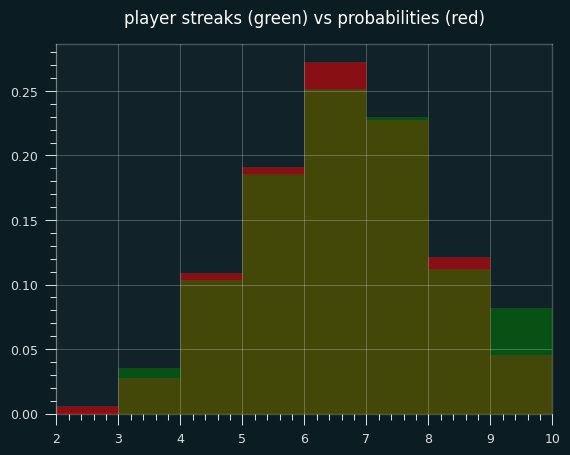

In [160]:
actual_streaks1 = clean_df[(clean_df.makes == 7) & (clean_df.misses == 4)]
actual_streaks2 = clean_df[(clean_df.makes == 4) & (clean_df.misses == 7)]

actual_streaks = pd.concat([actual_streaks1, actual_streaks2])

_hist1 = plt.hist(exact_df.streaks, density=True, bins=range(2,11), alpha=0.5, color='red')
_hist2= plt.hist(actual_streaks.total_streaks.astype("float"), bins=range(2,11), 
                 density=True, alpha=0.5, color='green')
_out = plt.title("player streaks (green) vs probabilities (red)")

In [227]:
actual_streaks.total_streaks.mean()

np.float64(6.199453551912568)

here are all the actual max-length streaks and counts. [TODO: include this in notebook?]

In [163]:
actual_streaks.loc[actual_streaks.total_streaks == 9].raw_data.value_counts()

raw_data
LLWLWLLWLWL    3
WLWWLWWLWLW    2
LWLLWLWLWLL    2
LWLWLLWLWLL    2
LWLWLWLLLWL    2
LWLWLLLWLWL    2
LLWLWLWLLWL    2
WLWWWLWLWLW    1
WWWLWLWLWLW    1
WLWLWWLWLWW    1
WLWLWWWLWLW    1
WLWLWLWWWLW    1
WWLWWLWLWLW    1
WLWLWLWLWWW    1
WLWLWWLWWLW    1
WLWWLWLWWLW    1
WWLWLWWLWLW    1
WLWWLWLWLWW    1
WWLWLWLWWLW    1
LWLLWLWLLWL    1
LWLLWLLWLWL    1
LLWLWLWLWLL    1
Name: count, dtype: int64

## Percentile rank z scores are lukewarm, too
Well, for all that windup, the percentile ranks didn't turn out all that different. The mean and median are still shifted to the un-streaky side, to a significant degree.

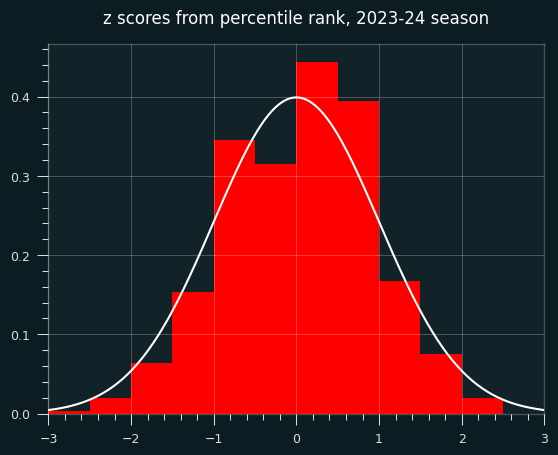

In [178]:
plot_z(clean_df.z_from_percentile_rank,
       "z scores from percentile rank, 2023-24 season")


Plotting the deciles shows an interesting tendency: a lot more values in the 60-70th percentile range than expected.

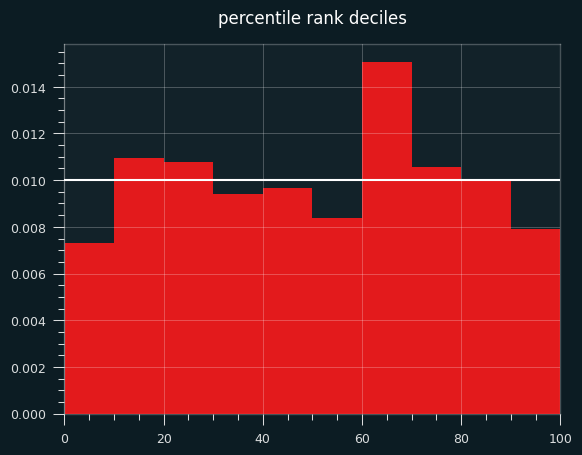

In [191]:
_out = plt.hist(clean_df.exact_percentile_rank, density=True)
_out = plt.hlines(.010, 0 ,100, colors="white")
_out = plt.title("percentile rank deciles")

In [51]:
clean_df.z_from_percentile_rank.describe()

count    18982.000000
mean         0.039683
std          0.893720
min         -3.403206
25%         -0.643522
50%          0.059717
75%          0.674490
max          3.823544
Name: z_from_percentile_rank, dtype: float64

here are the wald-wolfowitz z scores. The mean, median and std were all higher.

In [52]:
clean_df.z_score.astype("float").describe()

count    18982.000000
mean         0.051765
std          0.988789
min         -3.332292
25%         -0.707107
50%          0.104103
75%          0.816497
max          3.583243
Name: z_score, dtype: float64

diff in mean/median is still significant, though. Player field goals in individual games are still less streaky than predicted by chance.

In [53]:
sample_stdev = .8937/np.sqrt(18982)

p_value = 1 - scipy.stats.norm.cdf(.0397 / sample_stdev)

p_value

np.float64(5.145128767480855e-10)

# A weird continuity correction that's bad

SAS, the granddaddy of statistics software, applies a continuity correction to the runs test whenever the count is less than 50.

https://support.sas.com/kb/33/092.html

```
        if N GE 50 then Z = (Runs - mu) / sigma;
        else if Runs-mu LT 0 then Z = (Runs-mu+0.5)/sigma;
          else Z = (Runs-mu-0.5)/sigma;
```

Other implementations I looked at, like the one in R's [`randtests` package](https://www.rdocumentation.org/packages/randtests/versions/1.0.1/topics/runs.test), don't do the correction.


What does this sort of correction look like?

In [54]:
clean_df.loc[clean_df.total_streaks < clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks + .5) / ((clean_df.variance)**.5)
clean_df.loc[clean_df.total_streaks >= clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks - .5) / ((clean_df.variance)**.5)

this is a "z score in name only" because the std is so small.

In [55]:
clean_df.z_score_cc.astype("float").describe()

count    18982.000000
mean        -0.031954
std          0.687916
min         -3.047828
25%         -0.401101
50%          0.000000
75%          0.302765
max          3.390395
Name: z_score_cc, dtype: float64

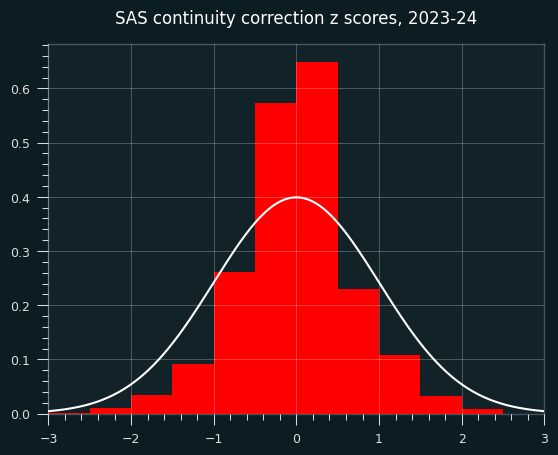

In [171]:
plot_z(clean_df.z_score_cc, "SAS continuity correction z scores, 2023-24", continuity=False)

That ain't normal.

## Correcting random data

I should also show what this looks like on truly random data. I will simulate a whole season using the code I wrote for the last installment. But I will use a simulated player with no streaky/unstreaky tendencies. Their results should look just like a coin flip, weighted to match the player's FG%.

In [57]:
import simulate_lukewarm
import streaky_players

sim = simulate_lukewarm.SimulateLukewarm(clean_df)
sim.player_type = streaky_players.NormalPlayer # FG% will always be their season average.
sim_summary = sim.sim_season()

season level results for each player:

In [58]:
sim_summary.head()

,actual,expected,variance,z_score
0,632,626.752561,308.312709,0.298849
1,248,226.641593,112.391323,2.014663
2,174,168.107246,80.691060,0.656003
3,9,7.857143,3.089482,0.650203
4,735,718.197772,357.948046,0.888090


calculating the Z score with SAS style continuity correction (these really should just be for samples < 50, but it doesn't matter for the point I'm making.)

In [ ]:
sim_summary.loc[sim_summary.actual < sim_summary.expected, 'z_score_cc'] = (
    sim_summary.actual - sim_summary.expected + .5) / ((sim_summary.variance)**.5)

sim_summary.loc[sim_summary.actual >= sim_summary.expected, 'z_score_cc'] = (
    sim_summary.actual - sim_summary.expected - .5) / ((sim_summary.variance)**.5)

Looking at all player seasons in 2023-24, it doesn't look too bad. The center is a bit higher than it should be, though.

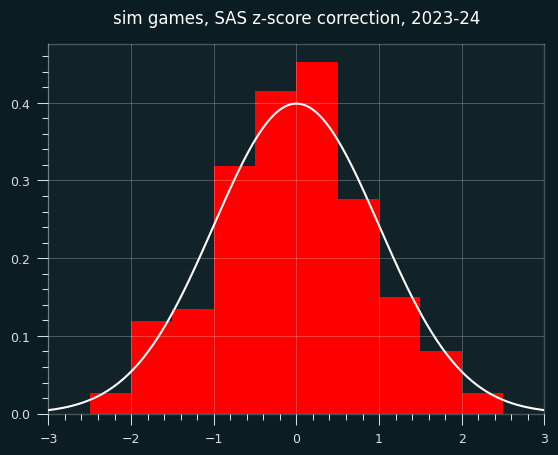

In [179]:
plot_z(sim_summary.z_score_cc, "sim games, SAS z-score correction, 2023-24")

The continuity correction especially stands out when looking at small sample sizes (in this case, simulated players with fewer than 30 shooting streaks over the course of the season).

In [61]:
sim_sss = sim_summary.z_score_cc[sim_summary.actual < 30]
sim_sss.describe()

count    116.000000
mean      -0.087423
std        0.817482
min       -1.871532
25%       -0.578478
50%       -0.020594
75%        0.337903
max        1.972697
Name: z_score_cc, dtype: float64

this is clearly wrong.

Red are the SAS corrected z-scores, green are the wald-wolfowitz z scores, brown are the overlap.

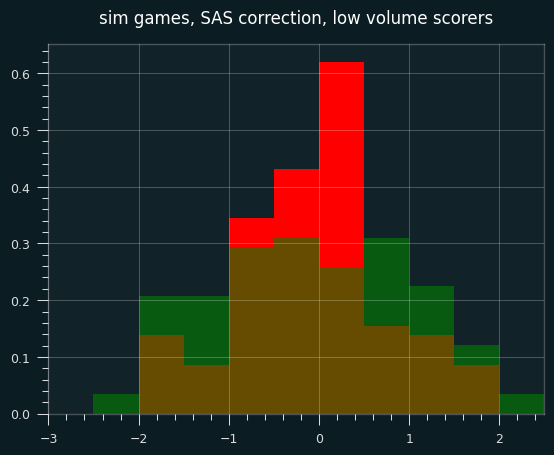

In [181]:
plot_z(sim_sss, "sim games, SAS correction, low volume scorers", do_bell=False)
_hist2 = plt.hist(sim_summary[sim_summary.actual < 30].z_score, density=True, color='green', 
                  alpha=.6, bins=np.arange(-3,3,.5))

Continuity corrections are at best an imperfect substitute for calculating the exact odds. These days, there's no reason not to use exact odds for small sample sizes. Even though it ended up not mattering much, I should've started with the percentile rank for individual games.